# Monte Carlo

### Contents

 * Prediction

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

sns.set()

# Prediction (Policy evaluation)

MC works for episodic learning. For each episode:
 * Track states visited in this episodes
 * Calculate the return $G_t$ for this state (using the discount $\gamma$)
 * the value function for state S is avarage return value
 
The continuous update rule is:

$$V(S_t) \leftarrow V(S_t) + \frac{1}{N(S_t)} (G_t-V(S_t))$$

This can be generalized to:

$$V(S_t) \leftarrow V(S_t) + \alpha (G_t-V(S_t))$$

This will allow to forget old episodes (Good for most typical non-stationary environments).

## Example 5.1 Blackjack

Rewards:
 * +1 - winning
 * 0  - draw
 * -1 - loosing
 * 0 - taking card
 
Helper functions 

In [7]:
def random_card():
    """ Random card generator
        1 = Ace
    """
    return random.randint(1,13)

def plot_values(vs):
    """Plot value function"""
    ax = sns.heatmap(vs, cmap="bwr")
    ax.invert_yaxis()
    plt.show()

def random_state():
    """Random starting state"""
    return (random.randint(1,10), random.randint(12,21))

def play_episode(state):
    """ Play episode from given state
        Return trance and score
    """
    values = state[1]
    trace = [values-12]
    # Take cards while sum less then 20
    while(values < 20):
        values += random_card()
        if values < 22:
            trace.append(values-12)
    if values < 22:
        # player has 20 or 21
        v2 = state[0]
        while v2 < values:
            v2 += random_card()
        if v2 == values:
            return (0, trace)
        elif v2 > values and v2 < 22:
            return (-1, trace)
        else:
            return (1, trace)            
    else:
        return (-1, trace)     

Show value function after 10K episodes:

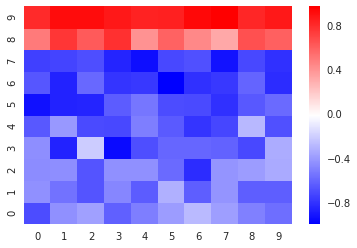

In [8]:
# Estimate value function for policy:
#  Take card if less then 20
V = np.zeros((10, 10))
alpha = 0.1
for _ in range(10**4):
    start_state = random_state()
    r, states = play_episode(start_state)
    d = start_state[0]-1
    for s in states:
        V[s,d] = V[s,d] + alpha * (r - V[s,d])

plot_values(V)   

After 1M episodes

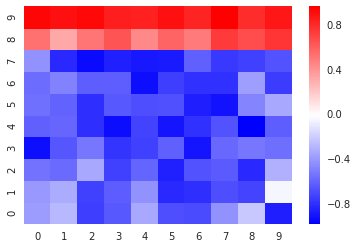

In [13]:
V = np.zeros((10, 10))
alpha = 0.1
for _ in range(10**6):
    start_state = random_state()
    r, states = play_episode(start_state)
    d = start_state[0]-1
    for s in states:
        V[s,d] = V[s,d] + alpha * (r - V[s,d])

plot_values(V)   